# Introduction

Welcome!

In this notebook I'm going to train transformers based models to do question answering. I will be using AdversarialQA dataset https://arxiv.org/pdf/2002.00293.pdf. This dataset was constucted using contexts from SQuAD dataset and models trained on SQuAD, only questions that trained models weren't able to answer were selected as main pourpose of this dataset was to be more demanding that already existing ones.

I will be trying out different model architectures and training approaches.

In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
import pandas as pd
import numpy as np
from datasets import load_dataset
from datasets import DatasetDict
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from transformers import TFAutoModelForQuestionAnswering
from tqdm.auto import tqdm 
from collections import defaultdict
from datasets import load_metric, concatenate_datasets
from transformers import DataCollatorWithPadding
from transformers import DefaultDataCollator
from transformers import create_optimizer
import tensorflow as tf
from transformers.keras_callbacks import PushToHubCallback
from huggingface_hub import create_repo
from collections import defaultdict

In [ ]:
notebook_login()

# Preprocessing and exploring the data

I'm only using train and validation splits because testing split answers aren't publicly avaliable.

In [ ]:
dataset_train = load_dataset('adversarial_qa', 'adversarialQA', split='train')
dataset_val = load_dataset('adversarial_qa', 'adversarialQA', split='validation')

In [ ]:
datasets = DatasetDict({'train': dataset_train, 'validation': dataset_val})

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers', 'metadata'],
        num_rows: 3000
    })
})

In [ ]:
datasets['train'][0]

{'id': '7ba1e8f4261d3170fcf42e84a81dd749116fae95',
 'title': 'Brain',
 'context': 'Another approach to brain function is to examine the consequences of damage to specific brain areas. Even though it is protected by the skull and meninges, surrounded by cerebrospinal fluid, and isolated from the bloodstream by the blood–brain barrier, the delicate nature of the brain makes it vulnerable to numerous diseases and several types of damage. In humans, the effects of strokes and other types of brain damage have been a key source of information about brain function. Because there is no ability to experimentally control the nature of the damage, however, this information is often difficult to interpret. In animal studies, most commonly involving rats, it is possible to use electrodes or locally injected chemicals to produce precise patterns of damage and then examine the consequences for behavior.',
 'question': 'What sare the benifts of the blood brain barrir?',
 'answers': {'text': ['isolated

There are 30k unique questions and 2648 unique contexts in train dataset. Validation dataset have 3k unique questions and 416 unique contexts.

Some fields are nested so I'm going to flatten the dataset.

In [ ]:
datasets = datasets.flatten()

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'metadata.split', 'metadata.model_in_the_loop'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'metadata.split', 'metadata.model_in_the_loop'],
        num_rows: 3000
    })
})

In [ ]:
unique_contexts_train = defaultdict()
unique_contexts_valid = defaultdict()

In [ ]:
for row in datasets['train']:
  unique_contexts_train[row['context']] = 1
len(unique_contexts_train.keys())

2648

In [ ]:
for row in datasets['validation']:
  unique_contexts_valid[row['context']] = 1
len(unique_contexts_valid.keys())

416

Here is a function to display random example from training set.

In [ ]:
def display_example():
  sample = datasets['train'].shuffle().select([np.random.randint(0, len(datasets['train'])+1)])
  
  splitted = sample['context'][0].split('. ')
  context = '.\n'.join(splitted)

  print('context: \n')
  print(context)
  print('-------------'*5)
  print('question: ')
  print(sample['question'][0])
  print('-------------'*5)
  print('answer: ')
  print(sample['answers.text'][0][0])

In [ ]:
display_example()

context: 

During the First World War, Plymouth was the port of entry for many troops from around the Empire and also developed as a facility for the manufacture of munitions.
Although major units of the Royal Navy moved to the safety of Scapa Flow, Devonport was an important base for escort vessels and repairs.
Flying boats operated from Mount Batten.
-----------------------------------------------------------------
question: 
The act of moving through the air is called?
-----------------------------------------------------------------
answer: 
Flying


In [ ]:
model_checkpoint = "YituTech/conv-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
def get_lenghts(batch):
  lenghts = []
  inputs = tokenizer(
      batch['question'],
      batch['context']
  )
  for input_ids in inputs['input_ids']:
    lenghts.append(len(input_ids))

  return {'lenghts': lenghts}


In [ ]:
lenghts_total = datasets.map(get_lenghts,
                            remove_columns=datasets['train'].column_names,
                            batched=True)

In [ ]:
lenghts = pd.Series(lenghts_total['train']['lenghts'])

In [ ]:
lenghts.describe()

count    30000.000000
mean       166.815900
std         67.149895
min         37.000000
25%        125.000000
50%        155.000000
75%        198.000000
max        713.000000
dtype: float64

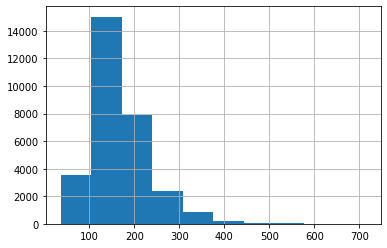

In [ ]:
lenghts.hist()

In [ ]:
len(lenghts[lenghts > 512])

50

50 question + context pairs from train dataset exceedes models maximum length of 512, so they will need to be split into two question + context samples with overlapping context in order to fit the model maximum length.

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'metadata.split', 'metadata.model_in_the_loop'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers.text', 'answers.answer_start', 'metadata.split', 'metadata.model_in_the_loop'],
        num_rows: 3000
    })
})

To compute loss function training samples need to have labels that are positions of start and end tokens of the answer.

To compute these labels later now I need to compute position where answers end in the string format. 

In [ ]:
def get_answer_end(batch):
  answer_end = []
  for start, text in zip(batch['answers.answer_start'], batch['answers.text']):
    answer_end.append(int(start[0]) + int(len(text[0])))
  return {'answer_end': answer_end}

In [ ]:
datasets = datasets.map(get_answer_end, batched=True)

In [ ]:
datasets = datasets.rename_column("answers.answer_start", "answer_start")


In [ ]:
datasets = datasets.rename_column("answers.text", "answer_text")

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'metadata.split', 'metadata.model_in_the_loop', 'answer_end'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'metadata.split', 'metadata.model_in_the_loop', 'answer_end'],
        num_rows: 3000
    })
})

I decided to start with ConvBert-Base model because it achieves better results on GLUE, SQUAD V1.1 and V2, than models of comparable size and its training times on various tasks are faster or the same. 

Cheat sheet I created helped me draw these conclusions.

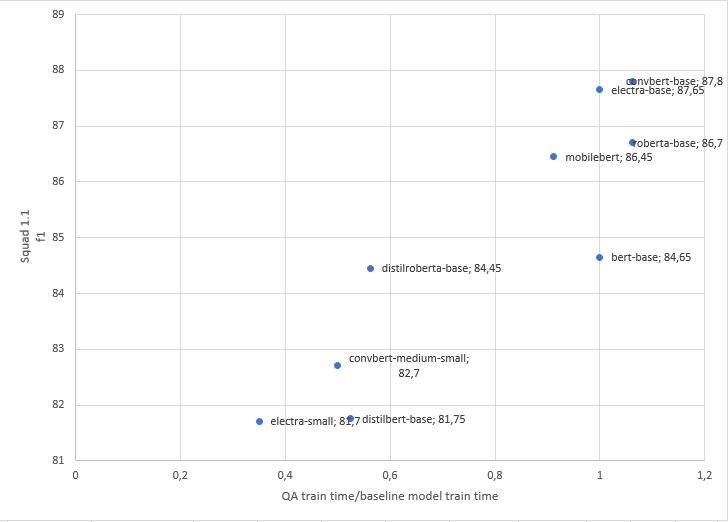

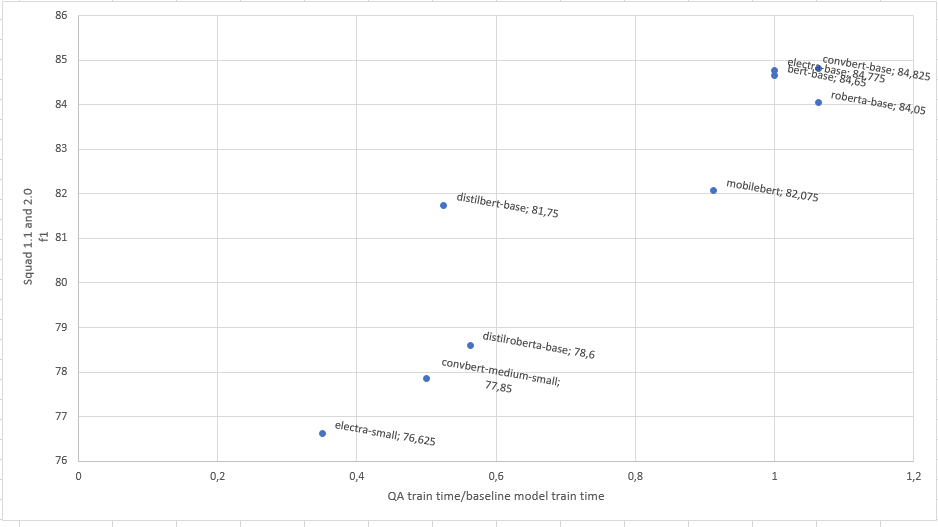

https://docs.google.com/spreadsheets/d/1g9NIKpO43ew5g0IJ_HKdLc_paV2NWMJL/edit?usp=sharing&ouid=113128350205455948201&rtpof=true&sd=true

Google spreadsheet messes up plots so If you want to use it you need to download it and open in excel.

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Question answering head put on top of ConvBert is returning 2 logits for every token. First one is score that this token is where answer starts and second one that answer ends on that token. Thats why qa_outputs have 1538 parameters 768*2=1536 weights transforming models final output vector of size 768 to vector with 2 numbers and 2 parameters for biases.

In [ ]:
model.summary()

Model: "tf_conv_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convbert (TFConvBertMainLay  multiple                 105680520 
 er)                                                             
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 105,682,058
Trainable params: 105,682,058
Non-trainable params: 0
_________________________________________________________________


If question + context pair after tokenization is longer than maximum sequence length of the model it needs to be split into multiple parts which overlap eachother. 

Every part looks like this [question, part of context] of size 512. Preprocessing function splits inputs in parts looking like this if necessary.

Labels for question answering task are positions of tokens where answer starts and ends. If one example got split up into multiple parts some parts may not contain the answer or only a part of it then label should be (0, 0).

In [ ]:
max_length = model.config.max_position_embeddings
stride = 256

def preprocess_for_training(batch):
  
  questions = [q.strip() for q in batch['question']]
  inputs = tokenizer(
      questions,
      batch['context'],
      max_length=max_length,
      truncation='only_second',
      stride=stride,
      return_overflowing_tokens=True,
      return_offsets_mapping=True
  )
  #offset mapping maps every token to its start and end position in string it was obtained from 
  offset_mapping = inputs.pop('offset_mapping')
  #overflow_to_sample_mapping maps tokenized samples to original samples 
  #for example if original sample was too long and exceded max length both resulting 
  #tokenized samples will be mapped to the same original sample
  sample_map = inputs.pop('overflow_to_sample_mapping')
  answers = batch['answer_text']
  start_pos = []
  end_pos = []
  answers_start = batch['answer_start']
  answers_end = batch['answer_end']

  #offset mapping is an array of arrays
  for i, offset in enumerate(offset_mapping):
    
    sample_idx = sample_map[i]
    start_char = answers_start[sample_idx]
    end_char = answers_end[sample_idx]
    sequence_ids = inputs.sequence_ids(i)

    #Finding start and end of context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx

    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    #if answer is not in context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char or offset[context_end][1] < end_char:
      start_pos.append(0)
      end_pos.append(0)

    else:
    #if answer is in the context its start and end tokens positions
      idx = context_start
      while offset[idx][0] < start_char:
        idx += 1
      start_pos.append(idx)

      while offset[idx][1] < end_char:
        idx += 1
      end_pos.append(idx)

  inputs['start_positions'] = start_pos
  inputs['end_positions'] = end_pos

  return inputs

answer_start and answer_test fields are strings inside of a list so they need to be unpacked.

In [ ]:
def unpack(batch):
  ans_start = []
  ans_text = []
  for start, text in zip(batch['answer_start'], batch['answer_text']):
    ans_start.append(start[0])
    ans_text.append(text[0])
  return {'answer_start': ans_start, 'answer_text': ans_text}

In [ ]:
datasets = datasets.map(unpack, batched=True)


  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
datasets['train'][0]

{'id': '7ba1e8f4261d3170fcf42e84a81dd749116fae95',
 'title': 'Brain',
 'context': 'Another approach to brain function is to examine the consequences of damage to specific brain areas. Even though it is protected by the skull and meninges, surrounded by cerebrospinal fluid, and isolated from the bloodstream by the blood–brain barrier, the delicate nature of the brain makes it vulnerable to numerous diseases and several types of damage. In humans, the effects of strokes and other types of brain damage have been a key source of information about brain function. Because there is no ability to experimentally control the nature of the damage, however, this information is often difficult to interpret. In animal studies, most commonly involving rats, it is possible to use electrodes or locally injected chemicals to produce precise patterns of damage and then examine the consequences for behavior.',
 'question': 'What sare the benifts of the blood brain barrir?',
 'answer_text': 'isolated from 

In [ ]:
train_dataset = datasets['train'].map(
    preprocess_for_training,
    batched=True,
    remove_columns = datasets['train'].column_names
)

  0%|          | 0/30 [00:00<?, ?ba/s]

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 30050
})

Preprocessing for validation doesn't require setting labels as start and end token because I won't be calculating validation loss during training. I will be calculating exact match and f1 score with metrics object provided by huggingface. Considering that only preprocessing step for validation data is tokenization.

In [ ]:
def preprocess_for_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs


In [ ]:
validation_dataset = datasets['validation'].map(
    preprocess_for_validation,
    batched=True,
    remove_columns=datasets['validation'].column_names
)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
metric = load_metric("squad")

To compute metrics for question answering (Exact match and F1) you need to have start and end logits, tokenized sample and original sample.

To get final answer im scoring n-best logits (20 in this case) with one another if they are valid meaning index of start logit is smaller than index of end logit and if start index - end index is smaller than maximum answer length (30 in this case).

After getting final answer metric.compute function from huggingface takes care of computing Exact match and F1 scores.

In [ ]:
def compute_metrics(start_logits, end_logits, features, examples, n_best=20, max_answer_length=30):
  examples_to_features = defaultdict(list)
  #mapping which feature (tokenized and possibly split example) coresponds to which example
  for idx, feature in enumerate(features):
    examples_to_features[feature['example_id']].append(idx)

  predicted_answers = []
  for example in tqdm(examples):
    example_id = example['id']
    context = example['context']
    answers = []

    # Loop through all features associated with that example
    for feature_index in examples_to_features[example_id]:
      #logits of one feature shaped [1, max_length]
      start_logit = start_logits[feature_index]
      end_logit = end_logits[feature_index]
      #offsets of one feature
      offsets = features[feature_index]['offset_mapping']

      start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
      end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()

      for start_index in start_indexes:
        for end_index in end_indexes:
          # If answer is not fully in the context nothing gets added
          if offsets[start_index] is None or offsets[end_index] is None or offsets[start_index] == [] or offsets[end_index] == []:
            continue

          if (
              end_index < start_index or
              end_index - start_index + 1 > max_answer_length
          ):
            continue

          answer = {
              'text': context[offsets[start_index][0] : offsets[end_index][1]],
              # im adding instead of multiplying because log(ab) = log(a) + log(b)
              'logit_score': start_logit[start_index] + end_logit[end_index]
          }
          answers.append(answer)
    #selecting answer with the best score
    if len(answers) > 0:
      best_answer = max(answers, key=lambda x: x['logit_score'])
      predicted_answers.append(
          {'id': example_id, 'prediction_text': best_answer['text']}
      )
    else:
      predicted_answers.append(
         {'id': example_id, 'prediction_text': ''}   
      )

  #original answers from dataset
  theoretical_answers = [
      {'id': ex['id'], 'answers': {'answer_start': [ex['answer_start']], 'text': [ex['answer_text']]}} for ex in examples
  ]
  #return predicted_answers, theoretical_answers
  return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
datasets['validation']

Dataset({
    features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'metadata.split', 'metadata.model_in_the_loop', 'answer_end'],
    num_rows: 3000
})

To put training samples in batches I'm using data collator which not only packs them together but also pads samples to the longest one in the batch.

This technique speeds up training because there is no need to perform computation over as many padding tokens as it would be necessary if all samples would be padded to the same size of max models input length (512 in case of ConvBert).



In [ ]:
data_collator = DataCollatorWithPadding(return_tensors='tf', tokenizer=tokenizer)

In [ ]:
data_collator_valid = DefaultDataCollator(return_tensors='tf')

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 30050
})

In [ ]:
validation_dataset

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 3000
})

I'm using batch size of 8 because batch size of 16 caused memory issues when I tried to run training on google colab.

In [ ]:
tf_train_dataset = train_dataset.to_tf_dataset(
  columns=[
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    batch_size=8,
    shuffle=True
)

tf_validation_dataset = validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    collate_fn=data_collator_valid,
    shuffle=False,
    batch_size=8
)

In [ ]:
results = pd.read_csv('/content/drive/MyDrive/QA/results.csv', index_col=[0])
results = np.round(results, 3)

In [ ]:
index = []
for idx in results.index:
  index.append(idx[:-1] + str(int(idx[-1]) + 1))

i = 0
for idx in index[:11]:
  index[i] = idx[:13] + str(int(idx[13]) + 1) + idx[14:]
  i += 1

for idx in index[11:24]:
  index[i] = idx[:12] + str(int(idx[12]) + 1) + idx[13:]
  i +=1

for idx in index[24:]:
  index[i] = idx[:12] + str(int(idx[12]) + 1) + idx[13:]
  i += 1


results.index = index

# Experiment's descriptions and results

From this moment onwards this notebook is just training different models and searching for optimal hyperparameters which is very repetitive so I will put descriptions of every training experiment here to save you unnecessary scrolling. Originally I was using notation for labeling experiments and epoch starting from 0 but for clarity I decided to change it to start from 1. In the section below everything will start from 1 but in code is starts from 0 

# ConvBert experiment 1

For first training experiment I'm using Adam with weight decay for optimization. Peak learning rate is 1e-4 decaying to 40% of that value over the course of 6 epochs. 1e-4 is in the middle of range Convbert authors were searching for when selecting learning rate for fine tuning. https://arxiv.org/pdf/2008.02496.pdf page 15. Peak learning rate will be achieved after 5% of total steps. Weight decay rate is 0.01. Both betas are set to their default values of 0.9 and 0.999.

After every epoch I will be saving models to huggingface hub and evaluating their performance. This will allow me to restore model's best weights in case of overfitting. I will do that for every model I'm going to train. 

These models aren't avaliable on my hugginface profil because I deleated them and kept only the best one.

After 6 epochs of training ConvBert achieved 32.3% exact match and 44,17% f1.

From epoch 2 to 4 results didn't improve but then they went up.

In [ ]:
results[:6]

,exact_match,f1
convbert_exp_1_epochs_1,27.267,38.214
convbert_exp_1_epochs_2,32.033,42.222
convbert_exp_1_epochs_3,31.400,42.765
convbert_exp_1_epochs_4,31.467,42.250
convbert_exp_1_epochs_5,32.267,43.059
convbert_exp_1_epochs_6,32.300,44.165


# ConvBert experiment 2

Because of results being stuck for several epochs in the last experiment I decided to use lower learning rate of 5e-5 and make it decay faster to achieve 20% of inital value at the end of training after 6 epochs. I also increased number of warmup steps from 5% to 8% of total training steps. Weight decay rate stayed the same.

Exact match score was improving for first three epochs and then started to go down. F1 score did improve for 4 epochs. Since after 5th epoch scores went down I decided to stop training and move on to another experiment .

In [ ]:
results[6:11]

,exact_match,f1
convbert_exp_2_epochs_1,30.567,42.544
convbert_exp_2_epochs_2,35.100,46.353
convbert_exp_2_epochs_3,36.400,47.730
convbert_exp_2_epochs_4,35.933,48.154
convbert_exp_2_epochs_5,34.900,47.980


# Electra experiment 1

Considering learning rate of 5e-5 did better job than 1e-4 when training ConvBert that is the value I decided to use for Electra. Initially I intended to train for 6 epochs with 5% of steps as warmup and learning rate decaying to 40% of 5e-5. Weight decay rate is 0.01. 

Given this training setup results did improve for 3 epochs but then they went down after 4th and 5th epochs so I stopped training.

In [ ]:
results[11:16]

,exact_match,f1
electra_exp_1_epochs_1,37.133,48.315
electra_exp_1_epochs_2,36.833,49.432
electra_exp_1_epochs_3,40.133,52.043
electra_exp_1_epochs_4,38.800,51.540
electra_exp_1_epochs_5,38.267,50.403


# Electra experiment 2

This time I wanted to use hyperparameters authors specified they used for finetuning in the electra paper (https://arxiv.org/pdf/2003.10555.pdf page 14).

I used learning rate of 1e-4 and turned off weight decay other parameters were the same as in last experiment. I stoppe training after 2 epochs because results were worse than after first epoch during previous experiment.

In [ ]:
results[16:18]

,exact_match,f1
electra_exp_2_epochs_1,29.533,40.048
electra_exp_2_epochs_2,33.433,44.156


# Electra experiment 3

During this experiment I used the same hyperparameters as in first electra experiment but turned off weight decay and learning rate decay.

I stopped after 1 epoch because model failed to train. 

In [ ]:
results[18:19]

,exact_match,f1
electra_exp_3_epochs_1,0.2,5.775


# Electra experiment 4

Previous model failed to train without learning rate decay so I tried using AMSGrad instead of ADAM. AMSGrad is identical to Adam but makes second moving average non-decreasing. With this change AMSGrad makes models converge to optimal solutions in some situations when Adam fails to do that, unfortunately that is not the case here. After one epoch results are looking ok but then go almost to zero.

In [ ]:
results[19:21]

,exact_match,f1
electra_exp_4_epochs_1,35.100,47.398
electra_exp_4_epochs_2,0.067,5.514


# Electra experiment 5

Knowing that learning rate decay is crucial and observing that models in previous experiments almost weren't improving after 3rd epoch I decided to train only for 3 epochs with learning rate decaying to 0. Initial learning rate is 5e-5, weight decay is turned off and number of warmup steps stays the same as in experiment 1.

With this approach I got the best results so far.

In [ ]:
results[21:24]

,exact_match,f1
electra_exp_5_epochs_1,37.233,48.628
electra_exp_5_epochs_2,41.600,52.941
electra_exp_5_epochs_3,41.633,53.403


# Roberta experiment 1

Observing that training for 3 epochs with learning rate decying to 0 is bringing the best results I decided to use this approach for roberta from the start. Number of warmup steps is 5% of total steps. Weight decay is set to 0.01 as specified in roberta paper. Peak learning rate is 1.5e-5 also specified in the paper although I didn't notice it was specified for roberta large not base.
Results I got were worse than these of the best electra's.

In [ ]:
results[24:-1]

,exact_match,f1
roberta_exp_1_epochs_1,34.533,45.816
roberta_exp_1_epochs_2,38.033,49.289
roberta_exp_1_epochs_3,39.467,51.163


# Roberta experiment 2

Seeing that previous experiment results didn't beat electra's I increased learning rate to 5e-5. All the other parameters stayed the same. 

Results after one epoch of training were worse than results during last experiment so I stopped training. 

In [ ]:
results[-1:]

,exact_match,f1
roberta_exp_2_epochs_1,32.3,43.396


# Final model

After all the training runs Electra achieved the best results of 41.633 exact match and 53.4 F1. These results were achieved after 3 epochs of training during experiment 5.

In [ ]:
results[-5:-4]

,exact_match,f1
electra_exp_5_epochs_3,41.633,53.403


Authors of Adversarial QA noticed that training on their dataset plus SQuAD brings performance improvment so I decided to do the same. I trained Electra on combined datasets using hyperparameters that I got the best results with. Additional training data improved both EM and F1 by 2%. SQuAD results are off by 14% on exact match and 6% on F1 compared to Electra's results reported in the paper. This gap could possibly be reduced by aditional hyperparameter search.


In [ ]:
results_aqa_squad = pd.read_csv('/content/drive/MyDrive/QA/results_aqa_squad.csv', index_col=[0])
results_aqa_squad

,exact_match,f1
electra_epochs_1_aqa,38.466667,50.145535
electra_epochs_1_squad,69.063387,82.799602
electra_epochs_2_aqa,42.900000,53.924034
electra_epochs_2_squad,71.144749,84.541577
electra_epochs_3_aqa,43.666667,55.546667
electra_epochs_3_squad,71.163671,84.796019


If you want to use this model you can do it using API hosted by Huggingface here https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3

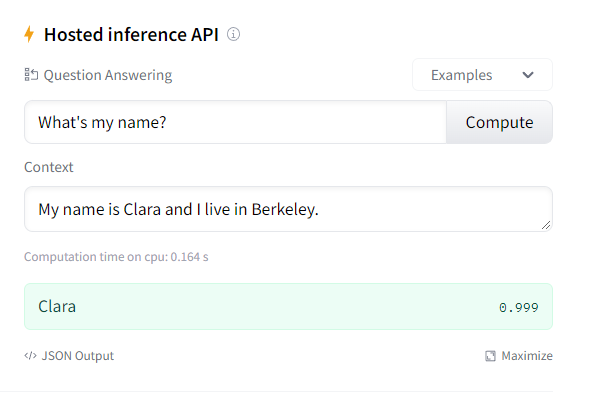

# ConvBert experiment 1 code

In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=1e-4,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    min_lr_ratio=0.4
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model.fit(tf_train_dataset, epochs=1, initial_epoch=0)

3757/3757 [==============================] - 1393s 364ms/step - loss: 2.9453


In [ ]:
exp_num = 0
epoch_num = 0


In [ ]:
def transform_to_df(results, index):
  return pd.DataFrame(results, index=[index])

In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_to_df(results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-0
   c9c9307..d2362ba  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-0
   c9c9307..d2362ba  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-0
   d2362ba..e17546e  main -> main

   d2362ba..e17546e  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.21426


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1379s 367ms/step - loss: 2.0258


In [ ]:
def transform_and_concat(results_df, results_to_add, index):
  temp_df = transform_to_df(results_to_add, index)
  return pd.concat([results_df, temp_df])

In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-1
   350890e..a31d218  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-1
   350890e..a31d218  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-1
   a31d218..1287868  main -> main

   a31d218..1287868  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 3/3
3757/3757 [==============================] - 1393s 371ms/step - loss: 1.3628


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-2
   4a07313..7d41138  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-2
   4a07313..7d41138  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-2
   7d41138..c776cd9  main -> main

   7d41138..c776cd9  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 4/4
3757/3757 [==============================] - 1389s 370ms/step - loss: 0.8854


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-3' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-3 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-3
   bd3290b..40d4aec  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-3
   bd3290b..40d4aec  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-3
   40d4aec..dea6839  main -> main

   40d4aec..dea6839  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 5/5
3757/3757 [==============================] - 1397s 372ms/step - loss: 0.5669


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-4' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-4 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-4
   760c7ea..2d31d28  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-4
   760c7ea..2d31d28  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-4
   2d31d28..d71e5a3  main -> main

   2d31d28..d71e5a3  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 6/6
3757/3757 [==============================] - 1377s 367ms/step - loss: 0.3554


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-0-epoch-5' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-5 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-5
   8cab937..293a82f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-5
   8cab937..293a82f  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-0-epoch-5
   293a82f..dba2d47  main -> main

   293a82f..dba2d47  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466


# ConvBert experiment 2 code

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFConvBertForQuestionAnswering.

Some layers of TFConvBertForQuestionAnswering were not initialized from the model checkpoint at YituTech/conv-bert-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.08),
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    min_lr_ratio=0.2
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
exp_num = 1
epoch_num = 0

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1381s 360ms/step - loss: 2.9390


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch_{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch_{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch_{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset, 
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-1-epoch_0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch_0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch_0
   ac65023..7bf1191  main -> main

   ac65023..7bf1191  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch_0
   7bf1191..e78b9ab  main -> main

   7bf1191..e78b9ab  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1347s 359ms/step - loss: 1.8036


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-1-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-1
   8e6c444..c148caa  main -> main

   8e6c444..c148caa  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-1
   c148caa..3ba2cf6  main -> main

   c148caa..3ba2cf6  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 3/3
3757/3757 [==============================] - 1350s 359ms/step - loss: 1.0847


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-1-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-2
   e1c5c1b..df74b56  main -> main

   e1c5c1b..df74b56  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-2
   df74b56..da59389  main -> main

   df74b56..da59389  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 4/4
3757/3757 [==============================] - 1352s 360ms/step - loss: 0.6381


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-1-epoch-3' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-3 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-3
   f7ef1ab..77df214  main -> main

   f7ef1ab..77df214  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-3
   77df214..c7e4b1c  main -> main

   77df214..c7e4b1c  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 5/5
3757/3757 [==============================] - 1355s 361ms/step - loss: 0.3736


In [ ]:
create_repo(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"convbert-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'convbert_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='convbert-base-adversarial-qa-exp-1-epoch-4' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-4 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/403M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-4
   684ceec..22e9108  main -> main

   684ceec..22e9108  main -> main

To https://huggingface.co/Gozdi/convbert-base-adversarial-qa-exp-1-epoch-4
   22e9108..a74ccce  main -> main

   22e9108..a74ccce  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Preprocessing for Electra 

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
max_length = model.config.max_position_embeddings
stride = 256

def preprocess_for_training(batch):
  
  questions = [q.strip() for q in batch['question']]
  inputs = tokenizer(
      questions,
      batch['context'],
      max_length=max_length,
      truncation='only_second',
      stride=stride,
      return_overflowing_tokens=True,
      return_offsets_mapping=True
  )
  #offset mapping maps every token to its start and end position in string it was obtained from 
  offset_mapping = inputs.pop('offset_mapping')
  #overflow_to_sample_mapping maps tokenized samples to original samples 
  #for example if original sample was too long and exceded max length both resulting 
  #tokenized samples will be mapped to the same original sample
  sample_map = inputs.pop('overflow_to_sample_mapping')
  answers = batch['answer_text']
  start_pos = []
  end_pos = []
  answers_start = batch['answer_start']
  answers_end = batch['answer_end']

  #offset mapping is an array of arrays
  for i, offset in enumerate(offset_mapping):
    
    sample_idx = sample_map[i]
    start_char = answers_start[sample_idx]
    end_char = answers_end[sample_idx]
    sequence_ids = inputs.sequence_ids(i)

    #Finding start and end of context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx

    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    #if answer is not in context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char or offset[context_end][1] < end_char:
      start_pos.append(0)
      end_pos.append(0)

    else:
    #if answer is in the context its start and end tokens positions
      idx = context_start
      while offset[idx][0] < start_char:
        idx += 1
      start_pos.append(idx)

      while offset[idx][1] < end_char:
        idx += 1
      end_pos.append(idx)

  inputs['start_positions'] = start_pos
  inputs['end_positions'] = end_pos

  return inputs

In [ ]:
def preprocess_for_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
train_dataset = datasets['train'].map(
    preprocess_for_training,
    batched=True,
    remove_columns = datasets['train'].column_names
)

  0%|          | 0/30 [00:00<?, ?ba/s]

In [ ]:
validation_dataset = datasets['validation'].map(
    preprocess_for_validation,
    batched=True,
    remove_columns=datasets['validation'].column_names
)

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
tf_train_dataset = train_dataset.to_tf_dataset(
  columns=[
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    batch_size=8,
    shuffle=True
)

tf_validation_dataset = validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    collate_fn=data_collator_valid,
    shuffle=False,
    batch_size=8
)

# Electra experiment 1 code

In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    min_lr_ratio=0.4
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
exp_num = 0
epoch_num = 0

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1276s 333ms/step - loss: 2.8112


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-0-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-0
   3d5a0cd..ed0efc3  main -> main

   3d5a0cd..ed0efc3  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-0
   ed0efc3..e76aab3  main -> main

   ed0efc3..e76aab3  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1247s 332ms/step - loss: 1.7606


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-0-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-1
   79e27f1..31e9d91  main -> main

   79e27f1..31e9d91  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-1
   31e9d91..2af0ee8  main -> main

   31e9d91..2af0ee8  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 3/3
3757/3757 [==============================] - 1252s 333ms/step - loss: 1.1260


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-0-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-2
   7e6a160..2e7a892  main -> main

   7e6a160..2e7a892  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-2
   2e7a892..5a9293b  main -> main

   2e7a892..5a9293b  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 4/4
3757/3757 [==============================] - 1249s 332ms/step - loss: 0.7254


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-0-epoch-3' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-3 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-3
   7b2ac3c..a6c07c8  main -> main

   7b2ac3c..a6c07c8  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-3
   a6c07c8..65bc474  main -> main

   a6c07c8..65bc474  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 5/5
3757/3757 [==============================] - 1251s 333ms/step - loss: 0.4618


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-0-epoch-4' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-4 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-4
   d8a4d2e..8893083  main -> main

   d8a4d2e..8893083  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-0-epoch-4
   8893083..6daec13  main -> main

   8893083..6daec13  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Electra experiment 2 code

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=1e-4,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0,
    min_lr_ratio=0.4
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
epoch_num = 0
exp_num = 1

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1232s 323ms/step - loss: 3.0967


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-1-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-0
   c5e2888..7fc486a  main -> main

   c5e2888..7fc486a  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-0
   7fc486a..2e30119  main -> main

   7fc486a..2e30119  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1208s 321ms/step - loss: 2.1543


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-1-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-1
   31c85cf..6e23749  main -> main

   31c85cf..6e23749  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-1-epoch-1
   6e23749..1b236bb  main -> main

   6e23749..1b236bb  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Electra experiment 3 code

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0,
    min_lr_ratio=1
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
epoch_num = 0
exp_num = 2

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1230s 322ms/step - loss: 4.1428


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-2-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-2-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-2-epoch-0
   72069ce..8886d06  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-2-epoch-0
   72069ce..8886d06  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-2-epoch-0
   8886d06..93f403f  main -> main

   8886d06..93f403f  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1212s 323ms/step - loss: 5.5936


In [ ]:
epoch_num = 0
exp_num = 3

In [ ]:
from transformers import AdamWeightDecay

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Electra experiment 4 code

In [ ]:
num_train_epochs = 6
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0,
    min_lr_ratio=1
)

model.compile(optimizer=AdamWeightDecay(learning_rate=schedule,amsgrad=True))

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1261s 329ms/step - loss: 2.8228


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-3-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-0
   0d0cb08..a293f31  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-0
   0d0cb08..a293f31  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-0
   a293f31..ee05000  main -> main

   a293f31..ee05000  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1242s 330ms/step - loss: 5.3348


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-3-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-1
   2ab81fb..a43d91e  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-1
   2ab81fb..a43d91e  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-3-epoch-1
   a43d91e..22d6721  main -> main

   a43d91e..22d6721  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Electra experiment 5 code

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epoch_num = 0
exp_num = 4

In [ ]:
num_train_epochs = 3
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.025),
    num_train_steps=num_train_steps,
    weight_decay_rate=0,
    min_lr_ratio=0
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1230s 323ms/step - loss: 2.6655


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-4-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-0
   abd2c42..5f6e5ea  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-0
   abd2c42..5f6e5ea  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-0
   5f6e5ea..b6222d1  main -> main

   5f6e5ea..b6222d1  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1214s 323ms/step - loss: 1.5661


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-4-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-1
   1a096cc..246f39f  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-1
   1a096cc..246f39f  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-1
   246f39f..32887db  main -> main

   246f39f..32887db  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 3/3
3757/3757 [==============================] - 1213s 323ms/step - loss: 0.8708


In [ ]:
create_repo(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"electra-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'electra_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='electra-base-adversarial-qa-exp-4-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-2
   533d3d2..40a9f12  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-2
   533d3d2..40a9f12  main -> main

To https://huggingface.co/Gozdi/electra-base-adversarial-qa-exp-4-epoch-2
   40a9f12..ec83fac  main -> main

   40a9f12..ec83fac  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Preprocessing for roberta

In [ ]:
model_checkpoint = 'roberta-base'

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
max_length = model.config.max_position_embeddings
stride = 256

def preprocess_for_training(batch):
  
  questions = [q.strip() for q in batch['question']]
  inputs = tokenizer(
      questions,
      batch['context'],
      max_length=max_length,
      truncation='only_second',
      stride=stride,
      return_overflowing_tokens=True,
      return_offsets_mapping=True
  )
  #offset mapping maps every token to its start and end position in string it was obtained from 
  offset_mapping = inputs.pop('offset_mapping')
  #overflow_to_sample_mapping maps tokenized samples to original samples 
  #for example if original sample was too long and exceded max length both resulting 
  #tokenized samples will be mapped to the same original sample
  sample_map = inputs.pop('overflow_to_sample_mapping')
  answers = batch['answer_text']
  start_pos = []
  end_pos = []
  answers_start = batch['answer_start']
  answers_end = batch['answer_end']

  #offset mapping is an array of arrays
  for i, offset in enumerate(offset_mapping):
    
    sample_idx = sample_map[i]
    start_char = answers_start[sample_idx]
    end_char = answers_end[sample_idx]
    sequence_ids = inputs.sequence_ids(i)

    #Finding start and end of context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx

    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    #if answer is not in context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char or offset[context_end][1] < end_char:
      start_pos.append(0)
      end_pos.append(0)

    else:
    #if answer is in the context its start and end tokens positions
      idx = context_start
      while offset[idx][0] < start_char:
        idx += 1
      start_pos.append(idx)

      while offset[idx][1] < end_char:
        idx += 1
      end_pos.append(idx)

  inputs['start_positions'] = start_pos
  inputs['end_positions'] = end_pos

  return inputs

In [ ]:
def preprocess_for_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
train_dataset = datasets['train'].map(
    preprocess_for_training,
    batched=True,
    remove_columns = datasets['train'].column_names
)

validation_dataset = datasets['validation'].map(
    preprocess_for_validation,
    batched=True,
    remove_columns=datasets['validation'].column_names
)

tf_train_dataset = train_dataset.to_tf_dataset(
  columns=[
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    batch_size=8,
    shuffle=True
)

tf_validation_dataset = validation_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    collate_fn=data_collator_valid,
    shuffle=False,
    batch_size=8
)

  0%|          | 0/30 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

# Roberta experiment 1 code


In [ ]:
num_train_epochs = 3
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=1.5e-5,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    min_lr_ratio=0
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
exp_num = 0
epoch_num = 0

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1294s 339ms/step - loss: 2.8214


In [ ]:
create_repo(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'roberta_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='roberta-base-adversarial-qa-exp-0-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/474M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-0
   2e41ade..70e6548  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-0
   2e41ade..70e6548  main -> main

To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-0
   70e6548..92233b2  main -> main

   70e6548..92233b2  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 2/2
3757/3757 [==============================] - 1273s 339ms/step - loss: 1.9379


In [ ]:
create_repo(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'roberta_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='roberta-base-adversarial-qa-exp-0-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/474M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-1
   f72cb94..c4fada1  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-1
   f72cb94..c4fada1  main -> main

To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-1
   c4fada1..237e244  main -> main

   c4fada1..237e244  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

Epoch 3/3
3757/3757 [==============================] - 1277s 340ms/step - loss: 1.5413


In [ ]:
create_repo(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'roberta_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='roberta-base-adversarial-qa-exp-0-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/474M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-2
   7d42ce6..4a97ff6  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-2
   7d42ce6..4a97ff6  main -> main

To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-0-epoch-2
   4a97ff6..1fc5c6f  main -> main

   4a97ff6..1fc5c6f  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


# Roberta experiment 2 code

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All model checkpoint layers were used when initializing TFRobertaForQuestionAnswering.

Some layers of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
exp_num = 1
epoch_num = 0

In [ ]:
num_train_epochs = 3
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.05),
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
    min_lr_ratio=0
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num+1, initial_epoch=epoch_num)

3757/3757 [==============================] - 1292s 339ms/step - loss: 2.8332


In [ ]:
create_repo(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

model.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

tokenizer.push_to_hub(f"roberta-base-adversarial-qa-exp-{exp_num}-epoch-{epoch_num}")

predictions = model.predict(tf_validation_dataset)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_dataset,
    datasets["validation"],
)

results_df = transform_and_concat(results_df, results, f'roberta_exp_{exp_num}_epochs_{epoch_num}')

epoch_num += 1

results_df

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='roberta-base-adversarial-qa-exp-1-epoch-0' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-1-epoch-0 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/474M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-1-epoch-0
   faf2f8e..39df6c4  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-1-epoch-0
   faf2f8e..39df6c4  main -> main

To https://huggingface.co/Gozdi/roberta-base-adversarial-qa-exp-1-epoch-0
   39df6c4..b8f85fb  main -> main

   39df6c4..b8f85fb  main -> main



  0%|          | 0/3000 [00:00<?, ?it/s]

,exact_match,f1
convbert_exp_0_epochs_0,27.266667,38.214260
convbert_exp_0_epochs_1,32.033333,42.221636
convbert_exp_0_epochs_2,31.400000,42.764538
convbert_exp_0_epochs_3,31.466667,42.250368
convbert_exp_0_epochs_4,32.266667,43.058632
convbert_exp_0_epochs_5,32.300000,44.165466
convbert_exp_1_epochs_0,30.566667,42.544097
convbert_exp_1_epochs_1,35.100000,46.353136
convbert_exp_1_epochs_2,36.400000,47.729863
convbert_exp_1_epochs_3,35.933333,48.153561


In [ ]:
results_df.to_csv('/content/drive/MyDrive/QA/results.csv')

# Electra SQuAD + AdversarialQA code

In [ ]:
model_checkpoint = 'google/electra-base-discriminator'
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraForQuestionAnswering: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFElectraForQuestionAnswering were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
data_collator = DataCollatorWithPadding(return_tensors='tf', tokenizer=tokenizer)

In [ ]:
aqa_train = load_dataset('adversarial_qa', 'adversarialQA', split='train')
aqa_val = load_dataset('adversarial_qa', 'adversarialQA', split='validation')
squad_train = load_dataset('squad', split='train')
squad_test = load_dataset('squad', split='validation')

dataset_train = concatenate_datasets([aqa_train, squad_train])

datasets = DatasetDict({'train': dataset_train, 'validation_aqa': aqa_val, 'validation_squad': squad_test})

datasets = datasets.flatten()

datasets = datasets.map(get_answer_end, batched=True)

datasets = datasets.rename_column("answers.answer_start", "answer_start")
datasets = datasets.rename_column("answers.text", "answer_text")

datasets = datasets.map(unpack, batched=True)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/118 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/118 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
max_length = model.config.max_position_embeddings
stride = 256

def preprocess_for_training(batch):
  
  questions = [q.strip() for q in batch['question']]
  inputs = tokenizer(
      questions,
      batch['context'],
      max_length=max_length,
      truncation='only_second',
      stride=stride,
      return_overflowing_tokens=True,
      return_offsets_mapping=True
  )
  #offset mapping maps every token to its start and end position in string it was obtained from 
  offset_mapping = inputs.pop('offset_mapping')
  #overflow_to_sample_mapping maps tokenized samples to original samples 
  #for example if original sample was too long and exceded max length both resulting 
  #tokenized samples will be mapped to the same original sample
  sample_map = inputs.pop('overflow_to_sample_mapping')
  answers = batch['answer_text']
  start_pos = []
  end_pos = []
  answers_start = batch['answer_start']
  answers_end = batch['answer_end']

  #offset mapping is an array of arrays
  for i, offset in enumerate(offset_mapping):
    
    sample_idx = sample_map[i]
    start_char = answers_start[sample_idx]
    end_char = answers_end[sample_idx]
    sequence_ids = inputs.sequence_ids(i)

    #Finding start and end of context
    idx = 0
    while sequence_ids[idx] != 1:
      idx += 1
    context_start = idx

    while sequence_ids[idx] == 1:
      idx += 1
    context_end = idx - 1

    #if answer is not in context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char or offset[context_end][1] < end_char:
      start_pos.append(0)
      end_pos.append(0)

    else:
    #if answer is in the context its start and end tokens positions
      idx = context_start
      while offset[idx][0] < start_char:
        idx += 1
      start_pos.append(idx)

      while offset[idx][1] < end_char:
        idx += 1
      end_pos.append(idx)

  inputs['start_positions'] = start_pos
  inputs['end_positions'] = end_pos

  return inputs

In [ ]:
def preprocess_for_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'metadata.split', 'metadata.model_in_the_loop', 'answer_end'],
        num_rows: 117599
    })
    validation_aqa: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'metadata.split', 'metadata.model_in_the_loop', 'answer_end'],
        num_rows: 3000
    })
    validation_squad: Dataset({
        features: ['id', 'title', 'context', 'question', 'answer_text', 'answer_start', 'answer_end'],
        num_rows: 10570
    })
})

In [ ]:
train_dataset = datasets['train'].map(
    preprocess_for_training,
    batched=True,
    remove_columns = datasets['train'].column_names
)

validation_aqa = datasets['validation_aqa'].map(
    preprocess_for_validation,
    batched=True,
    remove_columns=datasets['validation_aqa'].column_names
)

validation_squad = datasets['validation_squad'].map(
    preprocess_for_validation,
    batched=True,
    remove_columns=datasets['validation_squad'].column_names
)

tf_train_dataset = train_dataset.to_tf_dataset(
  columns=[
        "input_ids",
        "start_positions",
        "end_positions",
        "attention_mask",
        "token_type_ids",
    ],
    collate_fn=data_collator,
    batch_size=8,
    shuffle=True
)

tf_validation_aqa = validation_aqa.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    collate_fn=data_collator_valid,
    shuffle=False,
    batch_size=8
)

tf_validation_squad = validation_squad.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'token_type_ids'],
    collate_fn=data_collator_valid,
    shuffle=False,
    batch_size=8
)

  0%|          | 0/118 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [ ]:
num_train_epochs = 3
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,
    num_warmup_steps=int(num_train_steps * 0.025),
    num_train_steps=num_train_steps,
    weight_decay_rate=0,
    min_lr_ratio=0
)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
epoch_num = 1

In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num, initial_epoch=epoch_num-1)

14722/14722 [==============================] - 4790s 324ms/step - loss: 1.4884


In [ ]:
create_repo(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

model.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

tokenizer.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='Electra-base-squad-adversarialqa-epoch-1' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-1 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-1
   d7eb507..cc8e07d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-1
   d7eb507..cc8e07d  main -> main

To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-1
   cc8e07d..9c510e8  main -> main

   cc8e07d..9c510e8  main -> main



'https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-1/commit/9c510e872966fc184ada59a87181cb0a248169f4'

In [ ]:
predictions = model.predict(tf_validation_aqa)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_aqa,
    datasets["validation_aqa"],
)

results_aqa_squad = transform_to_df(results, f'electra_epochs_{epoch_num}_aqa')

predictions = model.predict(tf_validation_squad)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_squad,
    datasets["validation_squad"],
)

results_aqa_squad = transform_and_concat(results_aqa_squad, results, f'electra_epochs_{epoch_num}_squad')

epoch_num += 1

results_aqa_squad

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

,exact_match,f1
electra_epochs_1_aqa,38.466667,50.145535
electra_epochs_1_squad,69.063387,82.799602


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num, initial_epoch=epoch_num-1)

Epoch 2/2
14722/14722 [==============================] - 4768s 324ms/step - loss: 0.9140


In [ ]:
create_repo(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

model.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

tokenizer.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='Electra-base-squad-adversarialqa-epoch-2' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-2 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-2
   0a09289..0ba2f72  main -> main

   0a09289..0ba2f72  main -> main

To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-2
   0ba2f72..aa58d76  main -> main

   0ba2f72..aa58d76  main -> main



'https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-2/commit/aa58d76b9741c280b213d5600796b425cf1518c6'

In [ ]:
predictions = model.predict(tf_validation_aqa)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_aqa,
    datasets["validation_aqa"],
)

results_aqa_squad = transform_and_concat(results_aqa_squad, results, f'electra_epochs_{epoch_num}_aqa')

predictions = model.predict(tf_validation_squad)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_squad,
    datasets["validation_squad"],
)

results_aqa_squad = transform_and_concat(results_aqa_squad, results, f'electra_epochs_{epoch_num}_squad')

epoch_num += 1

results_aqa_squad

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

,exact_match,f1
electra_epochs_1_aqa,38.466667,50.145535
electra_epochs_1_squad,69.063387,82.799602
electra_epochs_2_aqa,42.900000,53.924034
electra_epochs_2_squad,71.144749,84.541577


In [ ]:
model.fit(tf_train_dataset, epochs=epoch_num, initial_epoch=epoch_num-1)

Epoch 3/3
14722/14722 [==============================] - 4764s 324ms/step - loss: 0.5566


In [ ]:
create_repo(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

model.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

tokenizer.push_to_hub(f"Electra-base-squad-adversarialqa-epoch-{epoch_num}")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:42: FutureWarning: Deprecated positional argument(s) used in 'create_repo': pass token='Electra-base-squad-adversarialqa-epoch-3' as keyword args. From version 0.12 passing these as positional arguments will result in an error,
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:684: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3 into local empty directory.


Upload file tf_model.h5:   0%|          | 3.34k/416M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3
   f628f3d..e09a57d  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3
   f628f3d..e09a57d  main -> main

To https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3
   e09a57d..ec7f961  main -> main

   e09a57d..ec7f961  main -> main



'https://huggingface.co/Gozdi/Electra-base-squad-adversarialqa-epoch-3/commit/ec7f96191bcec99f08e60abe85cac083ea1367a3'

In [ ]:
model = TFAutoModelForQuestionAnswering.from_pretrained('Gozdi/Electra-base-squad-adversarialqa-epoch-3')

All model checkpoint layers were used when initializing TFElectraForQuestionAnswering.

All the layers of TFElectraForQuestionAnswering were initialized from the model checkpoint at Gozdi/Electra-base-squad-adversarialqa-epoch-3.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraForQuestionAnswering for predictions without further training.


In [ ]:
predictions = model.predict(tf_validation_aqa)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_aqa,
    datasets["validation_aqa"],
)

results_aqa_squad = transform_and_concat(results_aqa_squad, results, f'electra_epochs_{epoch_num}_aqa')

predictions = model.predict(tf_validation_squad)

results = compute_metrics(
    predictions["start_logits"],
    predictions["end_logits"],
    validation_squad,
    datasets["validation_squad"],
)

results_aqa_squad = transform_and_concat(results_aqa_squad, results, f'electra_epochs_{epoch_num}_squad')

epoch_num += 1

results_aqa_squad

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

,exact_match,f1
electra_epochs_1_aqa,38.466667,50.145535
electra_epochs_1_squad,69.063387,82.799602
electra_epochs_2_aqa,42.900000,53.924034
electra_epochs_2_squad,71.144749,84.541577
electra_epochs_3_aqa,43.666667,55.546667
electra_epochs_3_squad,71.163671,84.796019


In [ ]:
results_aqa_squad.to_csv('/content/drive/MyDrive/QA/results_aqa_squad.csv')